# First stage of Sempli project: Cleaning the data

In [18]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import seaborn as sns
# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading the data

In this part of the project we are loading the excel file and normalizing the json format presented in the columns 'expected_detail' and 'paid_detail'

After normalizing the data we delete rows where the state of the client were 'GRACE' or 'PENDING' because of the COVID situation present at the moment of the study ('GRACE'), and the missing values presented on 'PENDING'

In [3]:
path_file = "data_sempli_holberton.xlsx"
cols = ['client_id',
        'loan_schedule_id',
        'loan_id',
        'index',
        'expected_date',
        'state',
        'arrears_days',
        'paid_date',
        'expected_detail',
        'paid_detail']
data = pd.read_excel(path_file, sheet_name = 1, header = 0, usecols = cols).replace('NaT', np.nan)

def normalize_data(df, col_name):
    data = df[col_name].apply(json.loads)
    return pd.json_normalize(data)

expected = normalize_data(data,'expected_detail')
paid = normalize_data(data,'paid_detail')
data = data.join(expected).join(paid, rsuffix='_paid')
data = data[data.state != "GRACE"]
data = data[data.state != "PENDING"]
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,expected_detail,paid_detail,...,taxRetentionPercentage_paid,fngTotal_paid,fngValue_paid,fngPercent_paid,fngVatValue_paid,legalCharge_paid,fngVatPercent_paid,preLegalCharge_paid,feesPaid_paid,monthlyDeferredInterest_paid
1,2442,13696,592,6,2019-03-18,PAID,0,2019-03-18,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9273,43776,1831,3,2020-03-04,PAID,5,2020-03-09,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deleting unnecessary columns

After taking a look at the data, we came to the conclusion to use total_paid and total_expected values and delete the other variable presented on 'data_droped_columns'

In [4]:
data_droped_columns = ['penalty', 'interest', 'insurance', 'principal', 'taxRetentionValue',
                       'taxRetentionPercentage', 'legalCharge', 'preLegalCharge', 'feesPaid',
                       'fngTotal', 'fngValue',
                       'fngPercent', 'fngVatValue', 'fngVatPercent', 'monthlyDeferredInterest',
                       'penalty_paid', 'interest_paid', 'insurance_paid',
                       'principal_paid', 'taxRetentionValue_paid',
                       'taxRetentionPercentage_paid', 'legalCharge_paid',
                       'preLegalCharge_paid', 'feesPaid_paid', 'fngTotal_paid',
                       'fngValue_paid', 'fngPercent_paid', 'fngVatValue_paid',
                       'fngVatPercent_paid', 'monthlyDeferredInterest_paid']
data = data.drop(columns=data_droped_columns)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,expected_detail,paid_detail,total,total_paid
1,2442,13696,592,6,2019-03-18,PAID,0,2019-03-18,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",22872996.50,22872996.50
2,9273,43776,1831,3,2020-03-04,PAID,5,2020-03-09,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",7322168.42,7322168.42


### checking normalized values
After deleting the some columns, we check if the 'total' and 'total_paid' match to the one on 'expected_detail' for 'total' and 'paid_detail' for 'total_paid'

The next step is delete the rows with json format and organize the data by 'client_id'

In [5]:
unused_columns = ['expected_detail', 'paid_detail']
data = data.drop(columns=unused_columns)
data = data.sort_values(by='client_id', ascending=True)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
861,14,82,14,8,2017-12-27,PAID,0,2017-12-27,1497723.06,1497723.06
5477,14,77,14,3,2017-07-27,PAID,0,2017-07-27,1497723.06,1497723.06


### Analyzing by loan ID 

At this stage we agreed to analyze how's the payment by loan_id on the last 6 months

In [6]:
data = data.sort_values(['client_id', 'loan_id', 'expected_date'])
data = data.groupby('loan_id').filter(lambda x : x['loan_id'].value_counts() > 6).groupby('loan_id').tail(6)
data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
5677,14,80,14,6,2017-10-27,PAID,4,2017-10-31,1497723.06,1497723.06
860,14,81,14,7,2017-11-27,PAID,0,2017-11-27,1499416.03,1499416.03
861,14,82,14,8,2017-12-27,PAID,0,2017-12-27,1497723.06,1497723.06
862,14,83,14,9,2018-01-29,PAID,0,2018-01-29,1497723.06,1497723.06
863,14,84,14,10,2018-02-27,PAID,0,2018-02-08,20078872.73,20078872.73
233,14,85,14,11,2018-03-27,PAID,0,2018-02-09,20018.84,20018.84
3742,141,2863,200,11,2019-08-26,PAID,0,2019-08-26,30141765.76,30141765.76
3743,141,2864,200,12,2019-09-25,PAID,0,2019-09-25,661183.89,661183.89
4954,141,2865,200,13,2019-10-25,PAID,0,2019-10-25,661183.89,661183.89
4956,141,2866,200,14,2019-11-25,PAID,0,2019-11-25,661183.89,661183.89


### Ploting the state behaviour of the clients

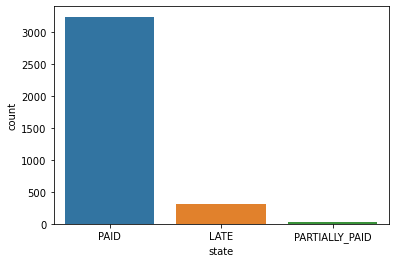

In [7]:
sns.countplot(x='state', data= data)

## Export data dataframe to an excel file

In [8]:
data.to_excel('output.xlsx')

### Loading cathegorical data

In [9]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data.head(3)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,...,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,7154.0,100000000,SP,25 a 36 meses,Industria,Scale Up,Medellín,4,Sí procesos judiciales,Sí Alertas,...,No LinkedIn,Si LinkedIn empresarios,57,Referrer,8,No Impacto,Si acceso a la banca,77,Si mujeres empresarias,3
1,646.0,320000000,KT - CO,Menos de 12 meses,Servicios,Scale Up,Medellín,4,No procesos judiciales,No Alertas,...,No LinkedIn,Si LinkedIn empresarios,36,Other,3,No Impacto,Si acceso a la banca,35,No mujeres empresarias,2
2,3934.0,300000000,SP,25 a 36 meses,Servicios,Scale Up,Medellín,5,No procesos judiciales,No Alertas,...,No LinkedIn,No LinkedIn empresarios,46,Other,5,No Impacto,No acceso a la banca,60,No mujeres empresarias,3


In [10]:
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,...,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No procesos judiciales,No Alertas,...,No LinkedIn,No LinkedIn empresarios,30,Internet,1,Si Impacto,Si acceso a la banca,110,No mujeres empresarias,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No procesos judiciales,No Alertas,...,Si LinkedIn,Si LinkedIn empresarios,45,Internet,2,No Impacto,Si acceso a la banca,16,No mujeres empresarias,2


In [11]:
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']

cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,...,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No,No,...,No,No,30,Internet,1,Si,Si,110,No,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,...,Si,Si,45,Internet,2,No,Si,16,No,2


In [19]:
clean_data = pd.DataFrame()
clean_data = data.merge(cat_data, left_on='client_id', right_on='ID Cliente')
clean_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,2016,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


In [21]:
clean_data.shape

(3492, 35)

In [13]:
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
clean_data = clean_data.drop(columns=cat_cols)

In [15]:
clean_data.to_excel('six_loan_id.xlsx')

In [16]:
clean_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73


In [17]:
clean_data['loan_id'].value_counts()

1595    6
1328    6
1264    6
1262    6
1260    6
       ..
971     6
903     6
839     6
837     6
20      6
Name: loan_id, Length: 582, dtype: int64